In [2]:
import os
import cv2
import numpy as np
import json 
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def get_slices(pano_path):
    equ = Equirectangular(pano_path)
    h_stride = 45
    nn_heading_angles = list(range(0, 360, h_stride))

    slices = list()
    for heading_angle in nn_heading_angles:
        img = equ.get_perspective(FOV=60,
                                  THETA=heading_angle,
                                  PHI=0,
                                  height=460,
                                  width=800)
        slices.append(img)
    return slices

In [4]:
def render_streetview_image(pano_id):
    pano_dir = '/data1/saaket/jpegs_manhattan_touchdown_2021/'
    slices_dir = '/data1/saaket/lsd_data/data/processed/pano_slices'
    pano_path = os.path.join(pano_dir, pano_id + '.jpg')

    equ = Equirectangular(pano_path)
    h_stride = 45
    nn_heading_angles = list(range(0, 360, h_stride))
    target_center = {'x': 0.37777777777777777, 'y': 0.5483333333333333}
    target_row = self.center['y']
    target_col = self.center['x']
    # target_image_num = target_row // (375)
    # target_row = target_row - (target_row // (375))*375 

    for i, heading_angle in enumerate(nn_heading_angles):
        img = equ.get_perspective(FOV=45,
                                  THETA=heading_angle,
                                  PHI=0,
                                  height=800,
                                  width=460,
                                  target_row=target_row,
                                  target_col=target_col)
        image_name = f'2_{pano_id}_{heading_angle}.jpg'
        image_path = os.path.join(slices_dir, image_name)
        cv2.imwrite(image_path, img)

In [6]:
with open('/data1/saaket/touchdown/data/train.json') as f:
    for line in f:
        obj = json.loads(line)
        break 
pano_id = 's5hIdomk5NlH-bCnQFDLXQ'
center_type = 'main' + '_static_center'
center = json.loads(obj[center_type])

In [7]:
row, col = int(center['y']*1500), int(center['y']*3000)

In [8]:
def get_perspective(img, target, FOV, THETA, PHI, height, width, RADIUS=128):
    img = np.array(img)
    img_height, img_width, _ = img.shape
    equ_h = img_height
    equ_w = img_width
    equ_cx = (equ_w - 1) / 2.0
    equ_cy = (equ_h - 1) / 2.0

    wFOV = FOV
    hFOV = float(height) / width * wFOV

    c_x = (width - 1) / 2.0
    c_y = (height - 1) / 2.0

    wangle = (180 - wFOV) / 2.0
    w_len = 2 * RADIUS * np.sin(np.radians(wFOV / 2.0)) / np.sin(np.radians(wangle))
    w_interval = w_len / (width - 1)

    hangle = (180 - hFOV) / 2.0
    h_len = 2 * RADIUS * np.sin(np.radians(hFOV / 2.0)) / np.sin(np.radians(hangle))
    h_interval = h_len / (height - 1)
    x_map = np.zeros([height, width], np.float32) + RADIUS
    y_map = np.tile((np.arange(0, width) - c_x) * w_interval, [height, 1])
    z_map = -np.tile((np.arange(0, height) - c_y) * h_interval, [width, 1]).T
    D = np.sqrt(x_map ** 2 + y_map ** 2 + z_map ** 2)
    xyz = np.zeros([height, width, 3], np.float)
    xyz[:, :, 0] = (RADIUS / D * x_map)[:, :]
    xyz[:, :, 1] = (RADIUS / D * y_map)[:, :]
    xyz[:, :, 2] = (RADIUS / D * z_map)[:, :]

    y_axis = np.array([0.0, 1.0, 0.0], np.float32)
    z_axis = np.array([0.0, 0.0, 1.0], np.float32)
    [R1, _] = cv2.Rodrigues(z_axis * np.radians(THETA))
    [R2, _] = cv2.Rodrigues(np.dot(R1, y_axis) * np.radians(-PHI))

    xyz = xyz.reshape([height * width, 3]).T
    xyz = np.dot(R1, xyz)
    xyz = np.dot(R2, xyz).T
    lat = np.arcsin(xyz[:, 2] / RADIUS)
    lon = np.zeros([height * width], np.float)
    theta = np.arctan(xyz[:, 1] / xyz[:, 0])
    idx1 = xyz[:, 0] > 0
    idx2 = xyz[:, 1] > 0

    idx3 = ((1 - idx1) * idx2).astype(np.bool)
    idx4 = ((1 - idx1) * (1 - idx2)).astype(np.bool)

    lon[idx1] = theta[idx1]
    lon[idx3] = theta[idx3] + np.pi
    lon[idx4] = theta[idx4] - np.pi

    lon = lon.reshape([height, width]) / np.pi * 180
    lat = -lat.reshape([height, width]) / np.pi * 180
    lon = lon / 180 * equ_cx + equ_cx
    lat = lat / 90 * equ_cy + equ_cy
    # for x in range(width):
    #    for y in range(height):
    #        cv2.circle(self._img, (int(lon[y, x]), int(lat[y, x])), 1, (0, 255, 0))
    # return self._img

    persp = cv2.remap(img, lon.astype(np.float32), lat.astype(np.float32), cv2.INTER_CUBIC,
                        borderMode=cv2.BORDER_WRAP)
    target = cv2.remap(target, lon.astype(np.float32), lat.astype(np.float32), cv2.INTER_CUBIC,
                        borderMode=cv2.BORDER_WRAP)
    return persp, target

In [9]:
img = Image.open(f'/data1/saaket/jpegs_manhattan_touchdown_2021/{pano_id}.jpg')

In [10]:
target = np.zeros((1500, 3000))

In [11]:
target[row, col] = 1

In [12]:
h_stride = 45
nn_heading_angles = list(range(0, 360, h_stride))

slices = list()
targets = list()
for heading_angle in nn_heading_angles:
    img_slice, target = get_perspective(img, target, FOV=60,
                            THETA=heading_angle,
                            PHI=0,
                            height=460,
                            width=800)
    slices.append(img_slice)
    targets.append(target)

/tmp/ipykernel_2830203/2187639468.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xyz = np.zeros([height, width, 3], np.float)
/tmp/ipykernel_2830203/2187639468.py:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = np.zeros([height * width], np.float)
/tmp/ipykernel_2830203/2187639468.py:45: DeprecationWarning: `np.bool` is a de

In [15]:
targets_stack = np.stack(targets, axis=0)

In [21]:
target_idx = np.unravel_index(targets_stack.argmax(), targets_stack.shape)

In [22]:
image = cv2.circle(slices[target_idx[0]], (target_idx[2], target_idx[1]), 5,    (0, 255, 0))

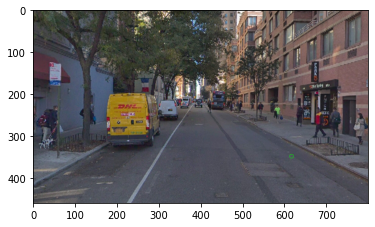

In [23]:
plt.imshow(image)
plt.show()

In [28]:
img_np = np.array(img)

In [31]:
x, y = int(center['x']*3000), int(center['y']*1500)

In [36]:
image2 = cv2.circle(img_np, (x, y), 100,    (0, 255, 0))

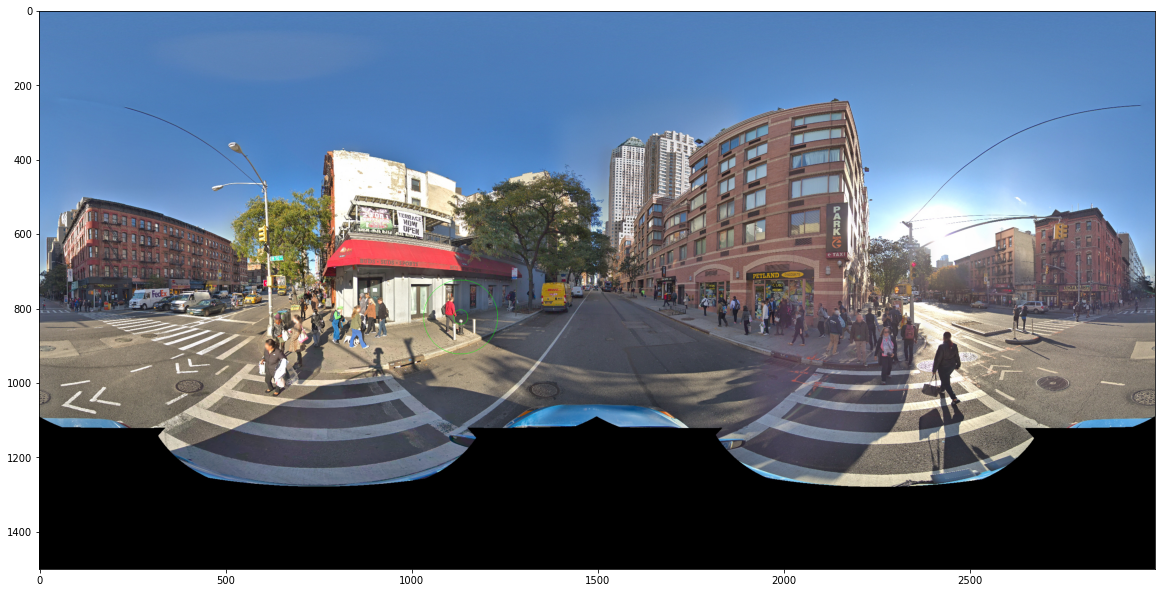

In [37]:
plt.figure(figsize = (20,20))
plt.imshow(image2)
plt.show()

In [25]:
obj['td_location_text']

"There's a black hydrant with a silver cap between two silver bollards on the sidewalk. Touchdown is on the cap of the hydrant."

In [43]:
targets_v = np.vstack((t for t in targets))

/tmp/ipykernel_2827397/2768282149.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  targets_v = np.vstack((t for t in targets))


In [44]:
targets_v.shape

(3680, 800)

In [20]:
img = get_perspective(img)

In [4]:

class Equirectangular:
    # https://github.com/fuenwang/Equirec2Perspec/blob/master/Equirec2Perspec.py
    def __init__(self, img_name):
        self._img = cv2.imread(img_name, cv2.IMREAD_COLOR)
        [self._height, self._width, _] = self._img.shape
        


    def get_perspective(self, FOV, THETA, PHI, height, width, RADIUS=128):
        #
        # THETA is left/right angle, PHI is up/down angle, both in degree
        #

        equ_h = self._height
        equ_w = self._width
        if do_target:
            target = np.zeros((self._height, self._width))
            target[target_row, target_col] = 1
        equ_cx = (equ_w - 1) / 2.0
        equ_cy = (equ_h - 1) / 2.0

        wFOV = FOV
        hFOV = float(height) / width * wFOV

        c_x = (width - 1) / 2.0
        c_y = (height - 1) / 2.0

        wangle = (180 - wFOV) / 2.0
        w_len = 2 * RADIUS * np.sin(np.radians(wFOV / 2.0)) / np.sin(np.radians(wangle))
        w_interval = w_len / (width - 1)

        hangle = (180 - hFOV) / 2.0
        h_len = 2 * RADIUS * np.sin(np.radians(hFOV / 2.0)) / np.sin(np.radians(hangle))
        h_interval = h_len / (height - 1)
        x_map = np.zeros([height, width], np.float32) + RADIUS
        y_map = np.tile((np.arange(0, width) - c_x) * w_interval, [height, 1])
        z_map = -np.tile((np.arange(0, height) - c_y) * h_interval, [width, 1]).T
        D = np.sqrt(x_map ** 2 + y_map ** 2 + z_map ** 2)
        xyz = np.zeros([height, width, 3], np.float)
        xyz[:, :, 0] = (RADIUS / D * x_map)[:, :]
        xyz[:, :, 1] = (RADIUS / D * y_map)[:, :]
        xyz[:, :, 2] = (RADIUS / D * z_map)[:, :]

        y_axis = np.array([0.0, 1.0, 0.0], np.float32)
        z_axis = np.array([0.0, 0.0, 1.0], np.float32)
        [R1, _] = cv2.Rodrigues(z_axis * np.radians(THETA))
        [R2, _] = cv2.Rodrigues(np.dot(R1, y_axis) * np.radians(-PHI))

        xyz = xyz.reshape([height * width, 3]).T
        xyz = np.dot(R1, xyz)
        xyz = np.dot(R2, xyz).T
        lat = np.arcsin(xyz[:, 2] / RADIUS)
        lon = np.zeros([height * width], np.float)
        theta = np.arctan(xyz[:, 1] / xyz[:, 0])
        idx1 = xyz[:, 0] > 0
        idx2 = xyz[:, 1] > 0

        idx3 = ((1 - idx1) * idx2).astype(np.bool)
        idx4 = ((1 - idx1) * (1 - idx2)).astype(np.bool)

        lon[idx1] = theta[idx1]
        lon[idx3] = theta[idx3] + np.pi
        lon[idx4] = theta[idx4] - np.pi

        lon = lon.reshape([height, width]) / np.pi * 180
        lat = -lat.reshape([height, width]) / np.pi * 180
        lon = lon / 180 * equ_cx + equ_cx
        lat = lat / 90 * equ_cy + equ_cy
        # for x in range(width):
        #    for y in range(height):
        #        cv2.circle(self._img, (int(lon[y, x]), int(lat[y, x])), 1, (0, 255, 0))
        # return self._img

        persp = cv2.remap(self._img, lon.astype(np.float32), lat.astype(np.float32), cv2.INTER_CUBIC,
                          borderMode=cv2.BORDER_WRAP)
        target = cv2.remap(target, lon.astype(np.float32), lat.astype(np.float32), cv2.INTER_CUBIC,
                          borderMode=cv2.BORDER_WRAP)
        return persp, target



In [11]:
render_streetview_image('s5hIdomk5NlH-bCnQFDLXQ')

/tmp/ipykernel_2822907/1680298439.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xyz = np.zeros([height, width, 3], np.float)
/tmp/ipykernel_2822907/1680298439.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = np.zeros([height * width], np.float)
/tmp/ipykernel_2822907/1680298439.py:54: DeprecationWarning: `np.bool` is a de

In [9]:
from PIL import Image 

In [ ]:
Image.open('/data1/saaket/jpegs_manhattan_touchdown_2021/zZQunI0Pn9wxHNdDb6ujFg.jpg')

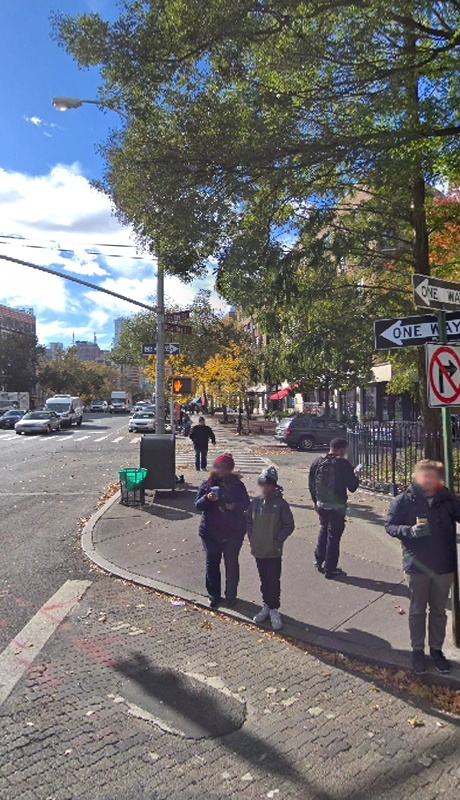

In [15]:
Image.open('/data1/saaket/lsd_data/data/processed/pano_slices/2_zZQunI0Pn9wxHNdDb6ujFg_45.jpg')

In [6]:
obj['main_pano']

's5hIdomk5NlH-bCnQFDLXQ'

In [12]:
center_type = 'main' + '_static_center'
center = json.loads(obj[center_type])

In [13]:
center

{'x': 0.37777777777777777, 'y': 0.5483333333333333}

In [17]:
col, row = int(center['x']*3000), int(center['y']*1500)

In [19]:
target = np.zeros((1500, 3000))

In [20]:
target[row, col] = 1